In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.losses import mean_squared_error as mse
from tensorflow.linalg import expm,logm
from numpy.random import multivariate_normal as mvn

from math import e

/home/teguh/.local/lib/python2.7/site-packages/sklearn/utils/__init__.py:9: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .murmurhash import murmurhash3_32
/home/teguh/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:24: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._logistic_sigmoid import _log_logistic_sigmoid
/home/teguh/.local/lib/python2.7/site-packages/sklearn/utils/extmath.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .sparsefuncs_fast import csr_row_norms
/home/teguh/.local/lib/python2.7/site-packages/sklearn/linear_model/base.py:35: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ..utils.seq_dataset import ArrayDataset, CSRDataset
/home/teguh/.local/lib/python2.7/site-packages/sklearn/linear_model/least_angle.py:23: RuntimeW

In [2]:
sess = tf.InteractiveSession()

In [3]:
def posterior(params, X, Y,batch_size=50):
    alpha = params[0]    
    YTY = np.dot(Y.T,Y)
    YTY = tf.constant(np.array([YTY]*batch_size).astype(np.float32))
    YTX = np.dot(Y.T,X)
    YTX = tf.constant(np.array([YTX]*batch_size).astype(np.float32))
    XTX = np.dot(X.T,X)    
    XTX = tf.constant(np.array([XTX]*batch_size).astype(np.float32))
    n = X.shape[0]
    d = X.shape[1]-1
    
    def func(theta):
        w = theta[:,:-1]
        lamda = tf.square(theta[:,-1:])
        val = 0.5*((n+1)*tf.log(2*np.pi) + tf.log(alpha) - n*tf.log(lamda))  + 0.5*(tf.matmul(tf.transpose(w,perm=[0,2,1]),w))
        val += 0.5*tf.matmul(lamda,(YTY - 2*tf.matmul(YTX,w) + tf.matmul(tf.transpose(w,perm=[0,2,1]), tf.matmul(XTX,w))))
        return val
    return func

In [4]:
def ELBO(params, X, Y, batch_size=50):
    d = int(samples.shape[1])
    n = int(samples.shape[0])
    posterior_data = posterior(params,X,Y, batch_size)   
    
    def func(mu,L,samples):
        L_sym = 0.5*(L+tf.transpose(L))
        mus = tf.tile(tf.expand_dims(mu,0),[batch_size,1,1]) 
        Ls = tf.tile(tf.expand_dims(L_sym,0),[batch_size,1,1])
        thetas = mus + tf.matmul(expm(Ls), samples)
        
        val = 0.5*d*(tf.log(2*np.pi)+1) + tf.trace(L)
        val -= tf.reduce_sum(posterior_data(thetas),0)/n
        return val
        
    return func

In [5]:
def predict(x, mu, Sigma):
    n = x.shape[0]
    d = x.shape[2]
    w = tf.tile(tf.expand_dims(mu[:-1],0), [n,1,1])
    sigma_w = tf.tile(tf.expand_dims(Sigma[:-1,:-1],0),[n,1,1])
    lamda =tf.tile(tf.expand_dims(1./tf.square(mu[-1:]),0), [n,1,1])
    
    y_pred = tf.matmul(x,w)
    y_cov = lamda + tf.matmul(x, tf.matmul(sigma_w,tf.transpose(x,perm=[0,2,1])))
    return y_pred,y_cov

In [6]:
def calc_MSLL(y_pred, y_cov, y_true, train_mean, train_var):
    n = y_pred.shape[0]
    MSLL = 0
    for i in range(n):
        SLL_trivial = 0.5*np.log(2*np.pi*train_var) + ((train_mean-y_true[i])**2)/(2*train_var)
        MSLL += 0.5*np.log(2*np.pi*y_cov[i]) + ((y_pred[i]-y_true[i])**2)/(2*y_cov[0]) - SLL_trivial
    MSLL /= n
    return MSLL

### Generate simple dataset 

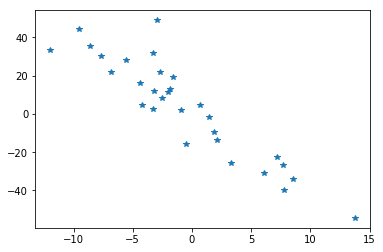

In [403]:
N= 30
X = np.hstack([np.ones((N,1)), 5*np.random.normal(size=(N,1))])
D = X.shape[1]
w_true = 3*np.random.normal(size=[D,1])
Y = np.dot(X,w_true) + 10*np.random.normal(size=[N,1])
plt.plot(X[:,1],Y,'*')

### GVA by minimizing -ELBO 

In [404]:
alpha = 10000.
params = [alpha]

D_in = X.shape[1]+1
D_out = 1
batch_size = 100

mu = tf.Variable(tf.random_normal(shape=(D_in,1)))
L = tf.Variable(tf.eye(D_in))

X = X.astype(np.float32)
Y = Y.astype(np.float32)

In [405]:
error_mse = mse(tf.matmul(X,mu[:-1]),Y)
post = posterior(params,X,Y,1)(tf.expand_dims(mu,0))
samples = tf.placeholder(tf.float32,shape=(batch_size, D_in,1))
elbo_data = ELBO(params, X, Y, batch_size)
elbo = elbo_data(mu,L,samples)

In [406]:
optimizer = tf.train.AdamOptimizer(0.1)
train = optimizer.minimize(-elbo,var_list=[mu,L])
sess.run(tf.global_variables_initializer())

#### Run Optimization

In [407]:
for i in range(3000):
    cur_samples = np.array([np.random.normal(np.zeros(D_in))[:,None] for j in range(batch_size)])
    _,elbo_,mu_,e_ = sess.run([train,elbo,mu,error_mse],feed_dict={samples:cur_samples})
    print i,elbo_,e_

0 [[-141715.86]] 1072.1345
1 [[-154041.78]] 1035.0231
2 [[-130555.375]] 998.65405
3 [[-62131.168]] 963.2652
4 [[-63924.07]] 930.1923
5 [[-46446.96]] 898.7539
6 [[-35522.273]] 869.23254
7 [[-37354.83]] 841.5369
8 [[-25650.97]] 815.1922
9 [[-19989.39]] 790.5333
10 [[-21647.17]] 767.58374
11 [[-14418.656]] 746.0041
12 [[-11364.896]] 725.9746
13 [[-10305.812]] 707.41656
14 [[-11794.986]] 690.20746
15 [[-8833.417]] 674.10626
16 [[-9140.564]] 659.13477
17 [[-8284.581]] 645.11633
18 [[-6608.6626]] 631.99695
19 [[-5249.147]] 619.7846
20 [[-5482.1455]] 608.44476
21 [[-3879.4946]] 597.87805
22 [[-3787.8186]] 588.08496
23 [[-3566.21]] 578.99066
24 [[-3767.7732]] 570.52264
25 [[-3606.749]] 562.6097
26 [[-3159.6138]] 555.2012
27 [[-3466.7422]] 548.2741
28 [[-2677.6575]] 541.7493
29 [[-3043.2136]] 535.6509
30 [[-2256.716]] 529.90485
31 [[-1740.7635]] 524.53723
32 [[-2268.5452]] 519.55066
33 [[-2598.2107]] 514.8561
34 [[-1704.3046]] 510.40814
35 [[-2024.768]] 506.24384
36 [[-1701.3761]] 502.30923
37 

300 [[-312.9427]] 241.77986
301 [[-270.66916]] 241.4051
302 [[-306.13757]] 241.04071
303 [[-243.34459]] 240.67772
304 [[-312.4884]] 240.32793
305 [[-298.7759]] 239.9769
306 [[-298.8158]] 239.62776
307 [[-333.98065]] 239.28017
308 [[-297.57394]] 238.92894
309 [[-287.18805]] 238.58047
310 [[-302.506]] 238.23564
311 [[-259.45273]] 237.89157
312 [[-255.77884]] 237.55573
313 [[-349.06656]] 237.2276
314 [[-291.91315]] 236.89229
315 [[-275.99908]] 236.55899
316 [[-313.747]] 236.22906
317 [[-308.54752]] 235.896
318 [[-334.70065]] 235.56075
319 [[-299.33585]] 235.21797
320 [[-287.71393]] 234.87524
321 [[-322.2652]] 234.53516
322 [[-300.0866]] 234.19135
323 [[-246.10675]] 233.84834
324 [[-277.74472]] 233.51584
325 [[-296.40164]] 233.18791
326 [[-302.7448]] 232.85857
327 [[-279.25623]] 232.52731
328 [[-272.68414]] 232.19948
329 [[-294.17084]] 231.87575
330 [[-274.0263]] 231.55267
331 [[-288.53418]] 231.23347
332 [[-299.3988]] 230.9143
333 [[-284.71436]] 230.59222
334 [[-254.19176]] 230.27151
335 

680 [[-225.1853]] 155.4748
681 [[-265.84265]] 155.34964
682 [[-274.3914]] 155.2114
683 [[-236.64041]] 155.0624
684 [[-265.75632]] 154.90814
685 [[-251.84348]] 154.74571
686 [[-256.9895]] 154.57753
687 [[-218.28952]] 154.40471
688 [[-217.45879]] 154.23273
689 [[-219.03279]] 154.06166
690 [[-186.96286]] 153.89027
691 [[-192.75534]] 153.72481
692 [[-195.36038]] 153.5641
693 [[-199.21796]] 153.40831
694 [[-186.6824]] 153.2554
695 [[-171.0934]] 153.10793
696 [[-189.00185]] 152.96896
697 [[-169.34654]] 152.83372
698 [[-174.05537]] 152.70485
699 [[-191.34488]] 152.58102
700 [[-185.23041]] 152.45847
701 [[-184.67502]] 152.33746
702 [[-172.77975]] 152.21768
703 [[-168.70966]] 152.10313
704 [[-166.61295]] 151.99379
705 [[-169.96962]] 151.88844
706 [[-164.65569]] 151.78734
707 [[-161.84938]] 151.6895
708 [[-167.73322]] 151.5952
709 [[-160.38919]] 151.50363
710 [[-169.32002]] 151.41483
711 [[-167.03056]] 151.32762
712 [[-157.15372]] 151.24356
713 [[-172.10497]] 151.16318
714 [[-169.6489]] 151.0837

1030 [[-182.40245]] 125.71014
1031 [[-170.45401]] 125.64396
1032 [[-163.8242]] 125.579994
1033 [[-183.02727]] 125.518715
1034 [[-167.77568]] 125.457306
1035 [[-170.60806]] 125.39842
1036 [[-156.80846]] 125.34218
1037 [[-164.42981]] 125.2888
1038 [[-164.11769]] 125.23801
1039 [[-159.04034]] 125.189384
1040 [[-169.08109]] 125.14353
1041 [[-165.5544]] 125.099655
1042 [[-162.26054]] 125.058716
1043 [[-174.13585]] 125.020035
1044 [[-180.95619]] 124.98246
1045 [[-171.93164]] 124.94487
1046 [[-161.83151]] 124.908195
1047 [[-163.35994]] 124.87261
1048 [[-170.84015]] 124.83738
1049 [[-177.3632]] 124.80226
1050 [[-172.73547]] 124.76871
1051 [[-172.97818]] 124.736
1052 [[-172.96513]] 124.7037
1053 [[-172.45369]] 124.67129
1054 [[-170.95763]] 124.639404
1055 [[-161.65002]] 124.6078
1056 [[-164.69943]] 124.57783
1057 [[-188.52338]] 124.54841
1058 [[-200.98973]] 124.518265
1059 [[-206.81682]] 124.48764
1060 [[-194.85895]] 124.45398
1061 [[-208.5653]] 124.41893
1062 [[-198.51855]] 124.38167
1063 [[-1

1367 [[-153.35635]] 111.74006
1368 [[-153.69774]] 111.74153
1369 [[-154.21307]] 111.74299
1370 [[-162.18193]] 111.74454
1371 [[-174.18166]] 111.7462
1372 [[-159.34926]] 111.74795
1373 [[-167.79945]] 111.74964
1374 [[-169.37166]] 111.75133
1375 [[-179.72876]] 111.75312
1376 [[-178.70064]] 111.75494
1377 [[-180.71408]] 111.75695
1378 [[-187.39786]] 111.75904
1379 [[-180.5093]] 111.76107
1380 [[-187.07341]] 111.76316
1381 [[-171.30429]] 111.76524
1382 [[-174.55894]] 111.76726
1383 [[-187.14386]] 111.76921
1384 [[-166.90503]] 111.77123
1385 [[-178.10844]] 111.7732
1386 [[-171.50974]] 111.775276
1387 [[-183.5537]] 111.77736
1388 [[-180.47658]] 111.779495
1389 [[-168.86488]] 111.781845
1390 [[-165.82056]] 111.78422
1391 [[-181.24165]] 111.7866
1392 [[-171.19179]] 111.78915
1393 [[-167.29515]] 111.7917
1394 [[-168.79118]] 111.79422
1395 [[-168.46463]] 111.79671
1396 [[-170.2634]] 111.799065
1397 [[-168.19179]] 111.801414
1398 [[-188.53864]] 111.803795
1399 [[-170.65828]] 111.806046
1400 [[-17

1733 [[-163.33875]] 112.39707
1734 [[-159.96693]] 112.39782
1735 [[-155.4779]] 112.398224
1736 [[-159.19029]] 112.3986
1737 [[-163.26184]] 112.39893
1738 [[-161.49931]] 112.39897
1739 [[-166.3364]] 112.399
1740 [[-163.49268]] 112.39886
1741 [[-154.75523]] 112.39837
1742 [[-158.99487]] 112.39802
1743 [[-156.26335]] 112.397484
1744 [[-153.58777]] 112.39678
1745 [[-161.75142]] 112.39624
1746 [[-157.03955]] 112.39565
1747 [[-156.12553]] 112.39511
1748 [[-153.16486]] 112.394485
1749 [[-147.67676]] 112.393936
1750 [[-152.92656]] 112.39364
1751 [[-151.20946]] 112.39347
1752 [[-154.40855]] 112.39335
1753 [[-148.75432]] 112.393166
1754 [[-150.35756]] 112.392975
1755 [[-148.01874]] 112.39278
1756 [[-147.02975]] 112.39261
1757 [[-149.95021]] 112.392426
1758 [[-150.46541]] 112.39247
1759 [[-150.06775]] 112.39254
1760 [[-147.16815]] 112.39274
1761 [[-153.73578]] 112.393166
1762 [[-155.76045]] 112.39375
1763 [[-156.30453]] 112.3944
1764 [[-153.62411]] 112.39516
1765 [[-152.30074]] 112.39613
1766 [[-

2033 [[-147.61551]] 112.34084
2034 [[-150.4324]] 112.339676
2035 [[-150.0135]] 112.338585
2036 [[-149.62033]] 112.33762
2037 [[-150.31749]] 112.33668
2038 [[-151.47754]] 112.336044
2039 [[-152.02422]] 112.33543
2040 [[-148.61427]] 112.334915
2041 [[-151.81906]] 112.3343
2042 [[-149.75583]] 112.333595
2043 [[-152.1012]] 112.33283
2044 [[-154.25798]] 112.332
2045 [[-153.3085]] 112.33117
2046 [[-168.59227]] 112.33024
2047 [[-160.52332]] 112.32894
2048 [[-164.32758]] 112.32751
2049 [[-169.40334]] 112.32567
2050 [[-166.07227]] 112.323555
2051 [[-178.46498]] 112.32116
2052 [[-169.73018]] 112.31823
2053 [[-163.18726]] 112.31495
2054 [[-166.9356]] 112.31177
2055 [[-168.98355]] 112.308464
2056 [[-166.30621]] 112.30516
2057 [[-169.19847]] 112.30156
2058 [[-164.06383]] 112.29797
2059 [[-168.91306]] 112.29426
2060 [[-158.93309]] 112.29039
2061 [[-156.38304]] 112.28666
2062 [[-154.00092]] 112.28325
2063 [[-156.7728]] 112.28013
2064 [[-148.90007]] 112.27722
2065 [[-153.99303]] 112.27475
2066 [[-151.

2336 [[-153.8256]] 111.84096
2337 [[-149.45395]] 111.84401
2338 [[-144.3699]] 111.84708
2339 [[-152.9518]] 111.850136
2340 [[-146.49606]] 111.853195
2341 [[-146.34491]] 111.856255
2342 [[-152.50378]] 111.85933
2343 [[-148.06223]] 111.86238
2344 [[-150.63882]] 111.86547
2345 [[-148.79176]] 111.8686
2346 [[-148.45804]] 111.87176
2347 [[-153.41966]] 111.87496
2348 [[-146.17622]] 111.87816
2349 [[-145.6556]] 111.881355
2350 [[-148.18193]] 111.884605
2351 [[-153.50336]] 111.887886
2352 [[-146.97235]] 111.891205
2353 [[-148.01714]] 111.89449
2354 [[-147.59915]] 111.89779
2355 [[-150.72304]] 111.90111
2356 [[-149.98395]] 111.90449
2357 [[-149.49838]] 111.90788
2358 [[-147.11539]] 111.91129
2359 [[-149.62105]] 111.91473
2360 [[-150.793]] 111.91814
2361 [[-148.11807]] 111.92161
2362 [[-151.09749]] 111.92507
2363 [[-150.50496]] 111.928566
2364 [[-147.82295]] 111.93208
2365 [[-150.23624]] 111.935616
2366 [[-147.68985]] 111.93911
2367 [[-153.27917]] 111.942665
2368 [[-148.23831]] 111.946236
2369 [

2642 [[-166.32973]] 111.65273
2643 [[-158.89223]] 111.65261
2644 [[-163.49596]] 111.652534
2645 [[-163.93486]] 111.6525
2646 [[-155.16368]] 111.65246
2647 [[-154.72298]] 111.65245
2648 [[-154.2341]] 111.65247
2649 [[-153.52211]] 111.65254
2650 [[-151.46239]] 111.65263
2651 [[-152.18452]] 111.65273
2652 [[-151.57683]] 111.65286
2653 [[-157.84691]] 111.65301
2654 [[-157.98505]] 111.65316
2655 [[-157.1107]] 111.653305
2656 [[-163.65955]] 111.65344
2657 [[-160.50409]] 111.65362
2658 [[-159.11238]] 111.65381
2659 [[-164.74274]] 111.65403
2660 [[-160.47345]] 111.65426
2661 [[-160.11609]] 111.65449
2662 [[-161.18909]] 111.65473
2663 [[-158.15233]] 111.65499
2664 [[-156.23718]] 111.6553
2665 [[-155.99475]] 111.655594
2666 [[-154.61894]] 111.655914
2667 [[-151.79813]] 111.656296
2668 [[-147.00656]] 111.65671
2669 [[-154.18051]] 111.65714
2670 [[-144.75374]] 111.65763
2671 [[-146.407]] 111.658134
2672 [[-148.15637]] 111.658714
2673 [[-147.12592]] 111.65932
2674 [[-144.71881]] 111.65994
2675 [[-1

2943 [[-1222.4945]] 111.63352
2944 [[-1163.2836]] 111.632805
2945 [[-1147.2148]] 111.63232
2946 [[-1089.7211]] 111.63176
2947 [[-1008.2023]] 111.63137
2948 [[-891.7845]] 111.63105
2949 [[-866.1489]] 111.63083
2950 [[-834.4556]] 111.63054
2951 [[-786.6455]] 111.63035
2952 [[-706.9272]] 111.63022
2953 [[-649.2063]] 111.63005
2954 [[-730.6645]] 111.629974
2955 [[-664.2619]] 111.62987
2956 [[-638.0784]] 111.62975
2957 [[-650.2366]] 111.62959
2958 [[-610.91205]] 111.62943
2959 [[-508.4086]] 111.629295
2960 [[-481.11356]] 111.629166
2961 [[-542.3311]] 111.629005
2962 [[-503.08066]] 111.62884
2963 [[-432.1596]] 111.6287
2964 [[-458.8836]] 111.62857
2965 [[-404.13773]] 111.628456
2966 [[-384.49133]] 111.62835
2967 [[-376.38162]] 111.62826
2968 [[-375.9168]] 111.628174
2969 [[-324.44858]] 111.62813
2970 [[-345.84433]] 111.6281
2971 [[-357.58664]] 111.62812
2972 [[-314.8598]] 111.62813
2973 [[-277.08655]] 111.62813
2974 [[-313.63083]] 111.62815
2975 [[-326.1381]] 111.628204
2976 [[-301.41125]] 1

### Plot

In [408]:
sigma_ = expm(2*L).eval()
sig = np.sqrt(1/(mu_[2,0]**2))
print mu_, w_true

[[ 0.6725392 ]
 [-4.0572205 ]
 [-0.15222116]] [[ 0.99749454]
 [-3.24850109]]


[ 0.55453705 -4.07083486 -0.36950276]
[ 0.60937665 -4.21652288 -0.15780572]
[ 0.64158584 -4.05683753 -0.21249326]
[ 0.78525805 -4.10088868  0.09851331]
[ 0.7575085  -4.15910762  0.08783396]
[ 0.65460373 -4.04186073 -0.19771736]
[ 0.64499314 -4.06406871 -0.19779315]
[ 0.65350812 -4.29032871 -0.01764852]
[ 0.65566894 -4.01021746 -0.2203977 ]
[ 0.52568181 -4.0669338  -0.43092406]
[ 0.72148195 -4.0574944  -0.05337255]
[ 0.66802897 -3.97812373 -0.22053432]
[ 0.79180423 -4.01936408  0.05274765]
[ 0.75006915 -3.96508334 -0.06891862]
[ 0.59384325 -4.18369105 -0.21220547]
[ 0.55570445 -4.25525551 -0.23530486]
[ 0.63761179 -3.84914693 -0.36863737]
[ 0.67422457 -4.05696796 -0.14865723]
[ 0.52994369 -4.28936991 -0.2583291 ]
[ 0.69804849 -4.06310216 -0.0994625 ]
[ 0.64878841 -4.06691507 -0.19157205]
[ 0.58921644 -3.912763   -0.41909424]
[ 0.73892131 -4.03831721 -0.03721257]
[ 0.57149363 -4.20603834 -0.23698196]
[ 7.44008086e-01 -4.07613957e+00  1.29228465e-03]
[ 0.64151909 -4.16179317 -0.13492016]


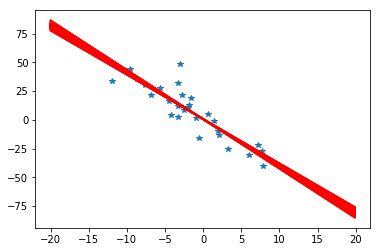

In [409]:
plt.plot(X[:,1],Y,'*')
x_test = np.arange(-20,20,0.1)[:,None]
X_test = np.hstack([np.ones((x_test.shape[0],1)),x_test])
for i in range(100):
    sample_mu = mvn(mu_[:,0], sigma_)
    print sample_mu
    y_pred = np.dot(X_test,sample_mu[:-1])
    plt.plot(x_test, y_pred, '-r')

### Test on SARCOS Inverse Dynamics

### Load Data 

In [7]:
from scipy.io import loadmat
data_train = loadmat('data/sarcos_inv.mat')
data_test = loadmat('data/sarcos_inv_test.mat')

x_train = data_train['sarcos_inv'][:,:21]
y_train = data_train['sarcos_inv'][:,21:22]
y_var = np.var(y_train)

x_test = data_test['sarcos_inv_test'][:,:21]
y_test = data_test['sarcos_inv_test'][:,21:22]

In [8]:
X  = np.hstack([np.ones((x_train.shape[0],1)), x_train])
Y = y_train.copy()

X_test = np.hstack([np.ones((x_test.shape[0],1)), x_test])
Y_test = y_test.copy()

### Standard Linear Regression

In [9]:
reg = 0.00001
w = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)+reg*np.eye(X.shape[1])),X.T),Y)

y_pred = np.dot(np.hstack([np.ones((x_train.shape[0],1)), x_train]), w)
smse_train = mean_squared_error(y_pred,y_train)/y_var
y_pred = np.dot(np.hstack([np.ones((x_test.shape[0],1)), x_test]), w)
smse_test = mean_squared_error(y_pred,y_test)/y_var

print smse_train,smse_test

0.07358881422797761 0.0742260930366048


## Bayesian Linear Regression

In [12]:
alpha = 10000.
params = [alpha]
D_in = X.shape[1]+1
D_out = 1
batch_size = 100

mu = tf.Variable(tf.random_normal(shape=(D_in,1)))
L = tf.Variable(tf.eye(D_in))
sigma = expm(2*L)

X = X.astype(np.float32)
Y = Y.astype(np.float32)

error_mse = mse(tf.matmul(X,mu[:-1]),Y)
post = posterior(params,X,Y,1)(tf.expand_dims(mu,0))
samples = tf.placeholder(tf.float32,shape=(batch_size, D_in,1))

elbo_data = ELBO(params, X, Y,batch_size)
elbo = elbo_data(mu,L,samples)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### Calculate Posterior Using GVA 

In [434]:
optimizer = tf.train.AdamOptimizer(0.1)
train = optimizer.minimize(-elbo,var_list=[mu,L])

sess.run(tf.global_variables_initializer())

In [435]:
for i in range(8000):
    cur_samples = np.array([np.random.normal(np.zeros(D_in))[:,None] for j in range(batch_size)])
    _,elbo_,mu_, sigma_, e_ = sess.run([train, elbo,mu,sigma,error_mse],feed_dict={samples:cur_samples})
    print i,elbo_,e_

0 [[-8.0564506e+08]] 1827.1796
1 [[-1.0885426e+09]] 1569.2535
2 [[-6.101695e+08]] 1348.5205
3 [[-5.719231e+08]] 1156.2207
4 [[-3.819594e+08]] 999.9661
5 [[-1.7620592e+08]] 876.2136
6 [[-1.688193e+08]] 784.631
7 [[-1.1707276e+08]] 719.0904
8 [[-1.0791372e+08]] 676.3361
9 [[-87964910.]] 650.42786
10 [[-58809190.]] 636.7321
11 [[-57924836.]] 631.7573
12 [[-68358130.]] 632.7433
13 [[-50292972.]] 637.6458
14 [[-49598428.]] 645.2952
15 [[-40063904.]] 653.83246
16 [[-34000184.]] 662.7735
17 [[-36697300.]] 671.446
18 [[-36003450.]] 678.9403
19 [[-32584762.]] 684.61273
20 [[-26609062.]] 688.41406
21 [[-26025424.]] 690.31177
22 [[-26623740.]] 690.35657
23 [[-20621052.]] 688.44257
24 [[-19256932.]] 685.3443
25 [[-16957984.]] 680.84204
26 [[-18701172.]] 675.26416
27 [[-17153252.]] 668.53235
28 [[-13371550.]] 661.0319
29 [[-15442412.]] 653.10724
30 [[-11674148.]] 644.67456
31 [[-14456579.]] 635.8098
32 [[-11570716.]] 626.71094
33 [[-12048317.]] 617.63666
34 [[-9449805.]] 608.29065
35 [[-10404206.]]

320 [[-834538.56]] 202.81207
321 [[-686955.2]] 202.40823
322 [[-936648.4]] 202.01686
323 [[-767176.9]] 201.62361
324 [[-925493.4]] 201.23837
325 [[-1067117.6]] 200.85028
326 [[-1006985.25]] 200.45322
327 [[-864128.7]] 200.05458
328 [[-968753.94]] 199.65755
329 [[-826996.3]] 199.2558
330 [[-710051.94]] 198.85905
331 [[-886390.2]] 198.47221
332 [[-768366.75]] 198.08556
333 [[-768375.25]] 197.70306
334 [[-689579.06]] 197.32475
335 [[-830526.2]] 196.95427
336 [[-858136.56]] 196.583
337 [[-818346.1]] 196.21234
338 [[-868932.44]] 195.83846
339 [[-873079.06]] 195.4655
340 [[-1071212.]] 195.0899
341 [[-1040065.3]] 194.69965
342 [[-890413.9]] 194.30002
343 [[-781803.]] 193.90019
344 [[-872616.8]] 193.50494
345 [[-858065.7]] 193.11247
346 [[-769114.75]] 192.72151
347 [[-784826.9]] 192.33531
348 [[-819175.9]] 191.95457
349 [[-648985.4]] 191.57391
350 [[-912658.5]] 191.20435
351 [[-947426.25]] 190.83043
352 [[-1011777.06]] 190.45154
353 [[-685860.1]] 190.06514
354 [[-667341.5]] 189.69095
355 [[-77

633 [[-401735.56]] 112.73459
634 [[-480919.1]] 112.581604
635 [[-452196.97]] 112.42416
636 [[-429349.2]] 112.267
637 [[-453679.8]] 112.1106
638 [[-361527.94]] 111.9529
639 [[-444251.5]] 111.79772
640 [[-394872.84]] 111.64055
641 [[-364870.6]] 111.48611
642 [[-366689.]] 111.33524
643 [[-397199.1]] 111.186615
644 [[-404939.47]] 111.04071
645 [[-394108.7]] 110.89479
646 [[-459477.84]] 110.7492
647 [[-458898.06]] 110.601006
648 [[-401024.2]] 110.4497
649 [[-417888.75]] 110.29876
650 [[-464014.28]] 110.14659
651 [[-395902.75]] 109.99382
652 [[-463480.38]] 109.84327
653 [[-405990.8]] 109.69265
654 [[-447087.28]] 109.54142
655 [[-425661.78]] 109.38839
656 [[-408082.22]] 109.2348
657 [[-449237.47]] 109.08192
658 [[-398817.3]] 108.925026
659 [[-369929.34]] 108.76851
660 [[-452362.97]] 108.61577
661 [[-392031.78]] 108.460724
662 [[-392373.8]] 108.307434
663 [[-373385.4]] 108.15636
664 [[-486045.06]] 108.008316
665 [[-356620.12]] 107.85693
666 [[-360885.25]] 107.70846
667 [[-431207.88]] 107.56364

926 [[-485113.7]] 69.5385
927 [[-364641.38]] 69.29056
928 [[-350967.4]] 69.058266
929 [[-425759.28]] 68.842834
930 [[-404326.97]] 68.63859
931 [[-375526.66]] 68.44393
932 [[-340890.5]] 68.260345
933 [[-419970.5]] 68.08657
934 [[-340911.16]] 67.91903
935 [[-360184.75]] 67.76017
936 [[-447637.03]] 67.60828
937 [[-366184.44]] 67.45962
938 [[-422027.94]] 67.31699
939 [[-398909.2]] 67.17631
940 [[-389384.72]] 67.03874
941 [[-358169.]] 66.90725
942 [[-411125.38]] 66.780716
943 [[-459010.28]] 66.65531
944 [[-371883.75]] 66.53087
945 [[-342061.44]] 66.409004
946 [[-323868.38]] 66.291405
947 [[-428756.56]] 66.17981
948 [[-352852.8]] 66.06887
949 [[-377470.7]] 65.96104
950 [[-314641.56]] 65.8537
951 [[-307157.66]] 65.750786
952 [[-367603.28]] 65.65378
953 [[-329812.8]] 65.559265
954 [[-367507.62]] 65.46626
955 [[-393427.06]] 65.37429
956 [[-290186.03]] 65.28219
957 [[-291439.75]] 65.19407
958 [[-295074.84]] 65.10831
959 [[-290453.25]] 65.026
960 [[-313610.1]] 64.946045
961 [[-339632.34]] 64.8673

1222 [[-247164.39]] 47.16126
1223 [[-251769.28]] 47.12999
1224 [[-237725.42]] 47.099155
1225 [[-263518.94]] 47.069023
1226 [[-301925.3]] 47.038727
1227 [[-258848.34]] 47.007904
1228 [[-256711.92]] 46.978218
1229 [[-279568.3]] 46.949284
1230 [[-247816.23]] 46.9204
1231 [[-236157.38]] 46.892544
1232 [[-261644.03]] 46.865356
1233 [[-252269.7]] 46.83857
1234 [[-236939.1]] 46.812943
1235 [[-263662.56]] 46.788094
1236 [[-270779.7]] 46.762695
1237 [[-242620.48]] 46.736343
1238 [[-274452.22]] 46.710606
1239 [[-222113.2]] 46.684826
1240 [[-254688.64]] 46.659904
1241 [[-249904.28]] 46.635853
1242 [[-272033.8]] 46.61233
1243 [[-265893.6]] 46.589188
1244 [[-215457.95]] 46.565994
1245 [[-240779.06]] 46.544186
1246 [[-272214.84]] 46.522835
1247 [[-251101.66]] 46.501392
1248 [[-248167.17]] 46.479774
1249 [[-270389.8]] 46.45794
1250 [[-238422.97]] 46.436207
1251 [[-260922.97]] 46.415028
1252 [[-270559.5]] 46.39243
1253 [[-268468.34]] 46.36996
1254 [[-318560.66]] 46.347282
1255 [[-376261.97]] 46.322067

1519 [[-232048.7]] 37.58046
1520 [[-279000.06]] 37.558105
1521 [[-225036.27]] 37.535477
1522 [[-237403.52]] 37.513077
1523 [[-253649.11]] 37.490536
1524 [[-358719.5]] 37.468586
1525 [[-1072776.5]] 37.43839
1526 [[-2172760.]] 37.389877
1527 [[-5480861.]] 37.33004
1528 [[-10109266.]] 37.811794
1529 [[-5605965.5]] 41.03842
1530 [[-3818893.5]] 48.883587
1531 [[-2536035.5]] 57.88759
1532 [[-3217871.]] 64.46953
1533 [[-3971604.8]] 65.079445
1534 [[-2744851.5]] 60.14496
1535 [[-3040610.8]] 53.24865
1536 [[-2654279.2]] 46.638596
1537 [[-3102247.5]] 43.004795
1538 [[-2580818.2]] 42.037445
1539 [[-2730952.5]] 42.58877
1540 [[-3050812.2]] 43.38185
1541 [[-2645592.2]] 43.30727
1542 [[-2647438.5]] 42.56917
1543 [[-2420802.5]] 41.22435
1544 [[-2128476.]] 40.137455
1545 [[-2045486.4]] 39.733143
1546 [[-1893438.9]] 39.913048
1547 [[-2025755.]] 40.42326
1548 [[-1945040.5]] 41.051563
1549 [[-1415298.9]] 41.332405
1550 [[-1684140.5]] 41.263493
1551 [[-1286588.4]] 40.95689
1552 [[-1326627.]] 40.42033
1553

1807 [[-220716.94]] 35.605835
1808 [[-251836.7]] 35.599266
1809 [[-221466.58]] 35.59592
1810 [[-246160.25]] 35.594707
1811 [[-246601.05]] 35.596226
1812 [[-219152.31]] 35.598106
1813 [[-226210.12]] 35.600433
1814 [[-271907.72]] 35.605297
1815 [[-222344.05]] 35.614815
1816 [[-217975.45]] 35.624767
1817 [[-222026.94]] 35.635456
1818 [[-249378.44]] 35.64505
1819 [[-274932.28]] 35.650475
1820 [[-331180.]] 35.652927
1821 [[-310178.9]] 35.636185
1822 [[-476741.84]] 35.613354
1823 [[-307972.2]] 35.557644
1824 [[-405941.66]] 35.504093
1825 [[-336181.5]] 35.453175
1826 [[-357563.94]] 35.405457
1827 [[-339344.16]] 35.365623
1828 [[-406176.88]] 35.33965
1829 [[-476161.16]] 35.325497
1830 [[-413873.72]] 35.333412
1831 [[-315738.44]] 35.37142
1832 [[-361364.5]] 35.44262
1833 [[-358271.28]] 35.542187
1834 [[-368849.25]] 35.636414
1835 [[-398177.22]] 35.721653
1836 [[-317876.53]] 35.83605
1837 [[-340751.38]] 35.9481
1838 [[-328132.38]] 36.03363
1839 [[-357091.28]] 36.125732
1840 [[-294184.34]] 36.210

2100 [[-186672.12]] 34.253857
2101 [[-192616.5]] 34.250294
2102 [[-220280.72]] 34.246613
2103 [[-191925.72]] 34.243046
2104 [[-195432.42]] 34.23955
2105 [[-196109.61]] 34.236225
2106 [[-185963.94]] 34.232998
2107 [[-205854.69]] 34.230015
2108 [[-190610.31]] 34.22715
2109 [[-198969.39]] 34.22412
2110 [[-198924.73]] 34.220818
2111 [[-186456.88]] 34.217377
2112 [[-204737.83]] 34.214233
2113 [[-201912.56]] 34.211
2114 [[-193624.81]] 34.207695
2115 [[-193207.17]] 34.204556
2116 [[-192071.08]] 34.20118
2117 [[-193678.92]] 34.197876
2118 [[-182603.48]] 34.194836
2119 [[-194864.86]] 34.192036
2120 [[-194308.3]] 34.189007
2121 [[-193856.78]] 34.18617
2122 [[-203714.56]] 34.18337
2123 [[-193789.5]] 34.18053
2124 [[-205177.88]] 34.177845
2125 [[-210125.1]] 34.174957
2126 [[-190523.6]] 34.172478
2127 [[-196470.53]] 34.16997
2128 [[-190474.39]] 34.167587
2129 [[-191972.94]] 34.16545
2130 [[-188658.25]] 34.163456
2131 [[-206458.25]] 34.161766
2132 [[-193327.72]] 34.1601
2133 [[-191674.34]] 34.158497

2384 [[-189424.44]] 34.199898
2385 [[-185598.94]] 34.19204
2386 [[-185209.77]] 34.183804
2387 [[-186891.72]] 34.17372
2388 [[-186963.02]] 34.16438
2389 [[-207934.11]] 34.156094
2390 [[-206710.27]] 34.14779
2391 [[-191252.34]] 34.141468
2392 [[-199954.2]] 34.135452
2393 [[-206245.39]] 34.128437
2394 [[-208428.53]] 34.123352
2395 [[-195058.48]] 34.119606
2396 [[-186973.56]] 34.116447
2397 [[-203383.86]] 34.113174
2398 [[-197529.97]] 34.108
2399 [[-202615.3]] 34.103203
2400 [[-193595.97]] 34.09726
2401 [[-193965.52]] 34.09071
2402 [[-198522.17]] 34.082706
2403 [[-196552.53]] 34.07673
2404 [[-217554.7]] 34.07045
2405 [[-199663.69]] 34.06708
2406 [[-203523.64]] 34.061573
2407 [[-196116.62]] 34.05614
2408 [[-191787.88]] 34.049072
2409 [[-192820.94]] 34.043114
2410 [[-191297.81]] 34.03681
2411 [[-190978.05]] 34.032803
2412 [[-190097.34]] 34.0286
2413 [[-197104.12]] 34.02444
2414 [[-189610.86]] 34.021236
2415 [[-183531.55]] 34.01806
2416 [[-191114.55]] 34.01597
2417 [[-195062.11]] 34.01172
241

2672 [[-196767.5]] 33.536137
2673 [[-192677.52]] 33.53655
2674 [[-189192.]] 33.53693
2675 [[-199520.11]] 33.537125
2676 [[-203319.58]] 33.538067
2677 [[-204081.39]] 33.5385
2678 [[-187961.16]] 33.539074
2679 [[-193797.39]] 33.539547
2680 [[-213329.83]] 33.539837
2681 [[-204659.03]] 33.540043
2682 [[-204093.25]] 33.54
2683 [[-193073.34]] 33.54044
2684 [[-206312.42]] 33.53994
2685 [[-193273.67]] 33.538925
2686 [[-191754.64]] 33.53761
2687 [[-201043.95]] 33.536495
2688 [[-202796.94]] 33.5356
2689 [[-197995.6]] 33.534805
2690 [[-197842.28]] 33.534264
2691 [[-203501.7]] 33.53349
2692 [[-194612.22]] 33.53272
2693 [[-196478.62]] 33.532013
2694 [[-191698.62]] 33.531765
2695 [[-196992.3]] 33.53168
2696 [[-192916.6]] 33.53167
2697 [[-199139.6]] 33.531693
2698 [[-198301.11]] 33.53147
2699 [[-211035.05]] 33.531605
2700 [[-204453.1]] 33.53211
2701 [[-208720.33]] 33.532623
2702 [[-193965.22]] 33.532993
2703 [[-212173.02]] 33.533516
2704 [[-189723.5]] 33.533966
2705 [[-204072.47]] 33.534092
2706 [[-1

2955 [[-743509.3]] 38.063892
2956 [[-782224.5]] 37.81179
2957 [[-751615.44]] 37.43174
2958 [[-788060.5]] 37.02163
2959 [[-753539.7]] 36.651848
2960 [[-789286.8]] 36.333862
2961 [[-831558.7]] 36.04297
2962 [[-692839.3]] 35.76084
2963 [[-726260.9]] 35.54114
2964 [[-734802.9]] 35.36279
2965 [[-673020.7]] 35.18007
2966 [[-672969.56]] 35.019318
2967 [[-688647.9]] 34.851753
2968 [[-611818.8]] 34.678806
2969 [[-607627.4]] 34.54728
2970 [[-631814.7]] 34.415295
2971 [[-547708.44]] 34.2737
2972 [[-537437.2]] 34.133083
2973 [[-520842.53]] 33.994392
2974 [[-504094.66]] 33.896835
2975 [[-474895.8]] 33.83202
2976 [[-478287.56]] 33.783657
2977 [[-473421.75]] 33.755978
2978 [[-447229.34]] 33.72994
2979 [[-475770.1]] 33.7077
2980 [[-399268.2]] 33.685383
2981 [[-388675.97]] 33.665848
2982 [[-373225.47]] 33.65292
2983 [[-398779.9]] 33.64659
2984 [[-357910.53]] 33.650974
2985 [[-330487.6]] 33.66488
2986 [[-356299.44]] 33.682465
2987 [[-353881.53]] 33.697483
2988 [[-336336.25]] 33.712124
2989 [[-303864.75]

3269 [[-180384.23]] 33.33651
3270 [[-172160.34]] 33.334904
3271 [[-173622.36]] 33.333687
3272 [[-173242.05]] 33.33245
3273 [[-170290.67]] 33.33308
3274 [[-165636.28]] 33.33408
3275 [[-166503.95]] 33.335075
3276 [[-172727.83]] 33.335518
3277 [[-169459.47]] 33.33667
3278 [[-171369.27]] 33.337738
3279 [[-180747.66]] 33.33897
3280 [[-176583.33]] 33.341106
3281 [[-174304.98]] 33.343735
3282 [[-173287.98]] 33.346226
3283 [[-175823.36]] 33.348587
3284 [[-167834.78]] 33.35023
3285 [[-172569.36]] 33.351234
3286 [[-170665.28]] 33.35261
3287 [[-171661.08]] 33.353447
3288 [[-168623.7]] 33.354404
3289 [[-171763.94]] 33.35444
3290 [[-164618.25]] 33.354214
3291 [[-168224.31]] 33.353252
3292 [[-170826.84]] 33.35279
3293 [[-173567.67]] 33.3518
3294 [[-169180.89]] 33.351982
3295 [[-166629.61]] 33.352413
3296 [[-170904.62]] 33.3531
3297 [[-172488.2]] 33.35312
3298 [[-179239.81]] 33.353943
3299 [[-174917.03]] 33.355064
3300 [[-172361.02]] 33.356846
3301 [[-170589.53]] 33.359146
3302 [[-171588.48]] 33.3612

3550 [[-167633.48]] 33.778347
3551 [[-167699.16]] 33.785614
3552 [[-169566.94]] 33.79251
3553 [[-168016.5]] 33.79719
3554 [[-169694.61]] 33.79858
3555 [[-170562.05]] 33.800236
3556 [[-169416.83]] 33.799652
3557 [[-164908.77]] 33.801277
3558 [[-169022.81]] 33.80084
3559 [[-169225.2]] 33.797417
3560 [[-167286.5]] 33.790974
3561 [[-171079.42]] 33.7838
3562 [[-170113.7]] 33.775684
3563 [[-168080.64]] 33.76604
3564 [[-168848.8]] 33.75747
3565 [[-162936.86]] 33.746944
3566 [[-169071.4]] 33.731983
3567 [[-171213.66]] 33.717575
3568 [[-173618.64]] 33.706047
3569 [[-167675.8]] 33.695343
3570 [[-172542.66]] 33.683056
3571 [[-171458.38]] 33.674778
3572 [[-171140.08]] 33.66971
3573 [[-166289.55]] 33.66436
3574 [[-171088.]] 33.6595
3575 [[-170325.11]] 33.653255
3576 [[-166567.8]] 33.6479
3577 [[-166779.61]] 33.642643
3578 [[-167924.92]] 33.63762
3579 [[-169519.78]] 33.633255
3580 [[-170869.39]] 33.63227
3581 [[-169702.98]] 33.63252
3582 [[-167981.11]] 33.63207
3583 [[-171049.]] 33.63073
3584 [[-166

3848 [[-159031.72]] 33.43525
3849 [[-154957.89]] 33.439293
3850 [[-161374.05]] 33.441856
3851 [[-154564.11]] 33.445744
3852 [[-159809.3]] 33.449093
3853 [[-163059.03]] 33.450542
3854 [[-160524.89]] 33.452297
3855 [[-158773.06]] 33.45413
3856 [[-162714.67]] 33.45462
3857 [[-157903.14]] 33.455433
3858 [[-156565.23]] 33.45538
3859 [[-159391.92]] 33.455338
3860 [[-159690.73]] 33.453743
3861 [[-159119.45]] 33.450676
3862 [[-163485.81]] 33.446953
3863 [[-158138.23]] 33.44286
3864 [[-160186.11]] 33.438713
3865 [[-158159.95]] 33.433495
3866 [[-161145.27]] 33.428085
3867 [[-156974.56]] 33.423798
3868 [[-160925.44]] 33.41983
3869 [[-161259.22]] 33.41517
3870 [[-161739.67]] 33.409935
3871 [[-160109.98]] 33.40531
3872 [[-159307.86]] 33.401054
3873 [[-156529.05]] 33.397358
3874 [[-159930.94]] 33.392944
3875 [[-160549.77]] 33.388737
3876 [[-160609.06]] 33.385086
3877 [[-156885.11]] 33.38194
3878 [[-158695.56]] 33.379383
3879 [[-154345.14]] 33.37613
3880 [[-160817.19]] 33.372883
3881 [[-159957.61]] 3

4129 [[-157306.34]] 33.27361
4130 [[-155450.27]] 33.273075
4131 [[-155801.]] 33.27224
4132 [[-158231.88]] 33.270874
4133 [[-156098.55]] 33.271164
4134 [[-158725.45]] 33.273052
4135 [[-155101.2]] 33.275414
4136 [[-159552.14]] 33.27719
4137 [[-160441.77]] 33.279186
4138 [[-154862.31]] 33.28182
4139 [[-155244.77]] 33.284298
4140 [[-154979.84]] 33.28582
4141 [[-154769.94]] 33.285885
4142 [[-155532.92]] 33.287277
4143 [[-154658.33]] 33.287594
4144 [[-157051.64]] 33.288193
4145 [[-154106.22]] 33.287434
4146 [[-157075.86]] 33.285774
4147 [[-157828.88]] 33.284447
4148 [[-155769.12]] 33.282703
4149 [[-156444.56]] 33.281372
4150 [[-155174.81]] 33.279427
4151 [[-157480.72]] 33.276764
4152 [[-158483.]] 33.273743
4153 [[-158096.47]] 33.270878
4154 [[-159332.8]] 33.26891
4155 [[-159266.69]] 33.26685
4156 [[-163822.28]] 33.264835
4157 [[-165779.25]] 33.26226
4158 [[-169624.75]] 33.260437
4159 [[-170595.25]] 33.258026
4160 [[-173518.8]] 33.254467
4161 [[-179402.1]] 33.250484
4162 [[-175258.12]] 33.247

4437 [[-152971.34]] 33.172802
4438 [[-151289.42]] 33.173264
4439 [[-151249.34]] 33.17352
4440 [[-153978.03]] 33.17372
4441 [[-151922.98]] 33.173973
4442 [[-149964.95]] 33.17388
4443 [[-151725.6]] 33.173634
4444 [[-151011.58]] 33.173725
4445 [[-151207.92]] 33.17377
4446 [[-151409.58]] 33.17381
4447 [[-151496.75]] 33.173294
4448 [[-151598.8]] 33.172585
4449 [[-153360.03]] 33.17177
4450 [[-150953.75]] 33.17127
4451 [[-152172.16]] 33.171276
4452 [[-150606.42]] 33.171864
4453 [[-153378.1]] 33.171833
4454 [[-149740.58]] 33.171562
4455 [[-154011.19]] 33.171265
4456 [[-153634.89]] 33.171387
4457 [[-152764.92]] 33.17176
4458 [[-154558.03]] 33.172867
4459 [[-152407.5]] 33.17453
4460 [[-151954.17]] 33.175613
4461 [[-150670.67]] 33.176548
4462 [[-152033.17]] 33.178013
4463 [[-152217.48]] 33.179474
4464 [[-151575.08]] 33.18058
4465 [[-150722.17]] 33.180515
4466 [[-150959.02]] 33.180336
4467 [[-151136.06]] 33.179424
4468 [[-157398.1]] 33.179558
4469 [[-150954.05]] 33.179413
4470 [[-150791.11]] 33.17

4718 [[-150394.45]] 33.13869
4719 [[-152243.27]] 33.13898
4720 [[-150896.77]] 33.139202
4721 [[-151119.]] 33.139442
4722 [[-150234.95]] 33.139706
4723 [[-150002.83]] 33.13975
4724 [[-148594.]] 33.139523
4725 [[-149896.14]] 33.13929
4726 [[-149152.6]] 33.139122
4727 [[-150040.89]] 33.139015
4728 [[-151995.56]] 33.139156
4729 [[-150259.81]] 33.1392
4730 [[-149462.78]] 33.139343
4731 [[-150800.25]] 33.139412
4732 [[-150700.94]] 33.13948
4733 [[-149801.33]] 33.13879
4734 [[-150005.67]] 33.138237
4735 [[-150655.94]] 33.137627
4736 [[-151440.92]] 33.137028
4737 [[-151570.89]] 33.136105
4738 [[-149264.31]] 33.135452
4739 [[-151218.5]] 33.134487
4740 [[-150107.02]] 33.133583
4741 [[-149525.52]] 33.13286
4742 [[-151945.61]] 33.132526
4743 [[-149715.89]] 33.132385
4744 [[-148962.17]] 33.132164
4745 [[-148472.52]] 33.131893
4746 [[-149550.27]] 33.131832
4747 [[-151515.67]] 33.131844
4748 [[-150391.14]] 33.13163
4749 [[-150954.42]] 33.13151
4750 [[-149299.56]] 33.131546
4751 [[-151106.95]] 33.1316

### Evaluate the result 

In [436]:
X_train_tf = tf.transpose((tf.expand_dims(X.astype(np.float32),2)),perm=[0,2,1])
X_test_tf = tf.transpose((tf.expand_dims(X_test.astype(np.float32),2)),perm=[0,2,1])

In [437]:
y_pred_train,y_cov_train = predict(X_train_tf, mu_, sigma_.astype(np.float32))
y_pred_test,y_cov_test = predict(X_test_tf, mu_, sigma_.astype(np.float32))
y_pred_train_,y_cov_train_, y_pred_test_,y_cov_test_  = sess.run([y_pred_train,y_cov_train, y_pred_test, y_cov_test])

#### Calculate Standard Mean Squared Error (SMSE)

In [438]:
smse_train = mse(y_pred_train[:,:,0],y_train)/y_var
smse_test = mse(y_pred_test[:,:,0],y_test)/y_var
smse_train_, smse_test_ = sess.run([mse_train, mse_test])
print 'SMSE training is ' + str(smse_train_)
print 'SMSE test is ' + str(smse_test_)

SMSE training is 0.0764784
SMSE test is 0.07718631


#### Calculate Mean Standard Log Loss (MSLL)

In [439]:
train_mean = np.mean(y_train)
train_var = np.var(y_train)

In [440]:
msll_train_ = calc_MSLL(y_pred_train_[:,0,0], (y_cov_train_[:,0,0]), y_train, train_mean, train_var)
msll_test_ = calc_MSLL(y_pred_test_[:,0,0], (y_cov_test_[:,0,0]), y_test, train_mean, train_var)
print 'MSLL training is ' + str(msll_train_)
print 'MSLL test is ' + str(msll_test_)

MSLL training is [-1.26559649]
MSLL test is [-1.25516098]


### Calculate Posterior Using Laplace Approximation 

In [13]:
optimizer = tf.train.AdamOptimizer(0.1)
train = optimizer.minimize(post,var_list=[mu])
sess.run(tf.global_variables_initializer())

In [14]:
for i in range(8000):
    _,post_,mu_, sigma_, e_ = sess.run([train, post,mu,sigma,error_mse])
    print i,post_,e_

0 [[[46217696.]]] 1664.6088
1 [[[32511538.]]] 1411.9503
2 [[[22477444.]]] 1195.9589
3 [[[15345559.]]] 1017.1041
4 [[[10399631.]]] 873.8235
5 [[[7027643.5]]] 762.77026
6 [[[4747252.]]] 679.4617
7 [[[3204419.5]]] 619.0354
8 [[[2153930.8]]] 576.85516
9 [[[1433204.4]]] 548.8629
10 [[[937602.75]]] 531.70874
11 [[[600880.9]]] 522.73395
12 [[[381341.62]]] 519.88
13 [[[253114.47]]] 521.5736
14 [[[203150.88]]] 526.6143
15 [[[272096.84]]] 534.0776
16 [[[207328.16]]] 543.2367
17 [[[213323.62]]] 553.50726
18 [[[255850.02]]] 564.407
19 [[[318614.38]]] 575.527
20 [[[392374.]]] 586.514
21 [[[469835.25]]] 597.0604
22 [[[544829.8]]] 606.9019
23 [[[612206.1]]] 615.81744
24 [[[667896.3]]] 623.63153
25 [[[709006.1]]] 630.21814
26 [[[733863.75]]] 635.50165
27 [[[741999.44]]] 639.45685
28 [[[734045.4]]] 642.10645
29 [[[711568.06]]] 643.5165
30 [[[676847.]]] 643.7883
31 [[[632627.9]]] 643.0514
32 [[[581876.75]]] 641.4532
33 [[[527555.06]]] 639.1507
34 [[[472435.66]]] 636.3016
35 [[[418965.1]]] 633.05804
36 [

422 [[[192565.7]]] 336.21225
423 [[[192534.73]]] 335.7434
424 [[[192503.83]]] 335.2761
425 [[[192473.]]] 334.8103
426 [[[192442.19]]] 334.3461
427 [[[192411.47]]] 333.88345
428 [[[192380.83]]] 333.42227
429 [[[192350.2]]] 332.96265
430 [[[192319.66]]] 332.50455
431 [[[192289.19]]] 332.04794
432 [[[192258.75]]] 331.59283
433 [[[192228.38]]] 331.13925
434 [[[192198.08]]] 330.68726
435 [[[192167.83]]] 330.23663
436 [[[192137.64]]] 329.7875
437 [[[192107.52]]] 329.33984
438 [[[192077.42]]] 328.89368
439 [[[192047.4]]] 328.449
440 [[[192017.45]]] 328.0058
441 [[[191987.55]]] 327.56403
442 [[[191957.75]]] 327.1237
443 [[[191927.94]]] 326.68478
444 [[[191898.22]]] 326.24738
445 [[[191868.56]]] 325.81134
446 [[[191838.95]]] 325.3767
447 [[[191809.4]]] 324.94354
448 [[[191779.9]]] 324.51172
449 [[[191750.48]]] 324.08133
450 [[[191721.11]]] 323.6523
451 [[[191691.78]]] 323.22476
452 [[[191662.5]]] 322.79852
453 [[[191633.31]]] 322.37363
454 [[[191604.16]]] 321.95016
455 [[[191575.05]]] 321.52805

849 [[[180915.47]]] 198.51625
850 [[[180883.81]]] 198.23137
851 [[[180852.12]]] 197.94655
852 [[[180820.4]]] 197.66174
853 [[[180788.62]]] 197.37701
854 [[[180756.83]]] 197.09229
855 [[[180724.97]]] 196.80759
856 [[[180693.05]]] 196.52298
857 [[[180661.14]]] 196.23837
858 [[[180629.14]]] 195.95384
859 [[[180597.11]]] 195.66933
860 [[[180565.06]]] 195.38486
861 [[[180532.95]]] 195.10042
862 [[[180500.8]]] 194.81607
863 [[[180468.62]]] 194.53174
864 [[[180436.4]]] 194.24744
865 [[[180404.14]]] 193.9632
866 [[[180371.83]]] 193.67899
867 [[[180339.45]]] 193.39484
868 [[[180307.08]]] 193.11073
869 [[[180274.64]]] 192.82668
870 [[[180242.17]]] 192.54266
871 [[[180209.62]]] 192.2587
872 [[[180177.08]]] 191.97478
873 [[[180144.48]]] 191.69095
874 [[[180111.84]]] 191.40712
875 [[[180079.12]]] 191.12332
876 [[[180046.4]]] 190.83965
877 [[[180013.62]]] 190.55597
878 [[[179980.81]]] 190.27237
879 [[[179947.97]]] 189.98883
880 [[[179915.08]]] 189.70534
881 [[[179882.14]]] 189.42186
882 [[[179849.12

1275 [[[163610.33]]] 90.22405
1276 [[[163563.11]]] 90.029236
1277 [[[163515.9]]] 89.834854
1278 [[[163468.67]]] 89.640884
1279 [[[163421.47]]] 89.44735
1280 [[[163374.25]]] 89.25425
1281 [[[163327.05]]] 89.06158
1282 [[[163279.83]]] 88.869316
1283 [[[163232.67]]] 88.677505
1284 [[[163185.47]]] 88.48614
1285 [[[163138.25]]] 88.29518
1286 [[[163091.12]]] 88.10465
1287 [[[163043.94]]] 87.91457
1288 [[[162996.78]]] 87.72494
1289 [[[162949.66]]] 87.53573
1290 [[[162902.47]]] 87.34696
1291 [[[162855.33]]] 87.158615
1292 [[[162808.19]]] 86.97072
1293 [[[162761.05]]] 86.78328
1294 [[[162713.95]]] 86.596245
1295 [[[162666.88]]] 86.409676
1296 [[[162619.77]]] 86.22354
1297 [[[162572.66]]] 86.03784
1298 [[[162525.58]]] 85.85261
1299 [[[162478.6]]] 85.66779
1300 [[[162431.56]]] 85.483444
1301 [[[162384.5]]] 85.29952
1302 [[[162337.48]]] 85.116066
1303 [[[162290.53]]] 84.933044
1304 [[[162243.5]]] 84.75047
1305 [[[162196.6]]] 84.56835
1306 [[[162149.62]]] 84.38668
1307 [[[162102.72]]] 84.20546
1308

1692 [[[148847.6]]] 45.797886
1693 [[[148827.62]]] 45.75583
1694 [[[148807.7]]] 45.71392
1695 [[[148787.78]]] 45.672165
1696 [[[148767.97]]] 45.630547
1697 [[[148748.14]]] 45.58908
1698 [[[148728.4]]] 45.54776
1699 [[[148708.75]]] 45.506588
1700 [[[148689.02]]] 45.465553
1701 [[[148669.44]]] 45.42466
1702 [[[148650.]]] 45.383907
1703 [[[148630.39]]] 45.3433
1704 [[[148610.98]]] 45.302834
1705 [[[148591.61]]] 45.262497
1706 [[[148572.25]]] 45.22231
1707 [[[148553.]]] 45.182255
1708 [[[148533.73]]] 45.142338
1709 [[[148514.48]]] 45.102566
1710 [[[148495.34]]] 45.06292
1711 [[[148476.2]]] 45.023415
1712 [[[148457.19]]] 44.984035
1713 [[[148438.16]]] 44.94479
1714 [[[148419.22]]] 44.905685
1715 [[[148400.27]]] 44.866703
1716 [[[148381.47]]] 44.827858
1717 [[[148362.62]]] 44.789143
1718 [[[148343.77]]] 44.75056
1719 [[[148325.08]]] 44.712105
1720 [[[148306.31]]] 44.67378
1721 [[[148287.78]]] 44.635574
1722 [[[148269.19]]] 44.597504
1723 [[[148250.67]]] 44.55956
1724 [[[148232.22]]] 44.52174

2054 [[[144025.44]]] 36.676975
2055 [[[144017.6]]] 36.66349
2056 [[[144009.69]]] 36.650036
2057 [[[144001.9]]] 36.636646
2058 [[[143994.27]]] 36.62329
2059 [[[143986.28]]] 36.60999
2060 [[[143978.6]]] 36.596737
2061 [[[143971.06]]] 36.583523
2062 [[[143963.27]]] 36.57036
2063 [[[143955.58]]] 36.55725
2064 [[[143948.06]]] 36.544178
2065 [[[143940.34]]] 36.531155
2066 [[[143932.86]]] 36.518177
2067 [[[143925.16]]] 36.505245
2068 [[[143917.67]]] 36.492363
2069 [[[143910.16]]] 36.47952
2070 [[[143902.69]]] 36.46673
2071 [[[143895.12]]] 36.453976
2072 [[[143887.77]]] 36.441273
2073 [[[143880.38]]] 36.42862
2074 [[[143872.95]]] 36.416008
2075 [[[143865.7]]] 36.40344
2076 [[[143858.25]]] 36.390915
2077 [[[143851.03]]] 36.378437
2078 [[[143843.64]]] 36.366005
2079 [[[143836.53]]] 36.35362
2080 [[[143829.23]]] 36.341274
2081 [[[143822.06]]] 36.32898
2082 [[[143814.81]]] 36.31672
2083 [[[143807.7]]] 36.30451
2084 [[[143800.58]]] 36.292347
2085 [[[143793.47]]] 36.28022
2086 [[[143786.39]]] 36.268

2467 [[[142394.77]]] 33.903797
2468 [[[142393.45]]] 33.90132
2469 [[[142391.81]]] 33.898857
2470 [[[142390.5]]] 33.896408
2471 [[[142389.1]]] 33.893967
2472 [[[142387.78]]] 33.891537
2473 [[[142386.25]]] 33.88911
2474 [[[142384.95]]] 33.886707
2475 [[[142383.6]]] 33.884308
2476 [[[142382.33]]] 33.88192
2477 [[[142380.84]]] 33.87954
2478 [[[142379.38]]] 33.87717
2479 [[[142378.22]]] 33.87481
2480 [[[142376.83]]] 33.872467
2481 [[[142375.61]]] 33.870125
2482 [[[142374.28]]] 33.867798
2483 [[[142372.94]]] 33.865482
2484 [[[142371.53]]] 33.863174
2485 [[[142370.27]]] 33.860874
2486 [[[142369.03]]] 33.858585
2487 [[[142367.6]]] 33.856308
2488 [[[142366.39]]] 33.85404
2489 [[[142365.11]]] 33.851784
2490 [[[142363.8]]] 33.84953
2491 [[[142362.39]]] 33.84729
2492 [[[142361.1]]] 33.845066
2493 [[[142359.89]]] 33.842842
2494 [[[142358.77]]] 33.840633
2495 [[[142357.48]]] 33.838432
2496 [[[142356.31]]] 33.836243
2497 [[[142354.98]]] 33.834057
2498 [[[142353.81]]] 33.83188
2499 [[[142352.53]]] 33.

2900 [[[142102.58]]] 33.385532
2901 [[[142102.2]]] 33.384964
2902 [[[142101.89]]] 33.38439
2903 [[[142101.44]]] 33.383816
2904 [[[142101.16]]] 33.383244
2905 [[[142100.97]]] 33.382675
2906 [[[142100.53]]] 33.382103
2907 [[[142100.19]]] 33.381535
2908 [[[142099.92]]] 33.38097
2909 [[[142099.52]]] 33.380405
2910 [[[142099.19]]] 33.379837
2911 [[[142099.]]] 33.379276
2912 [[[142098.53]]] 33.37871
2913 [[[142098.23]]] 33.37815
2914 [[[142097.77]]] 33.37759
2915 [[[142097.47]]] 33.377026
2916 [[[142097.1]]] 33.376472
2917 [[[142096.77]]] 33.37591
2918 [[[142096.55]]] 33.375355
2919 [[[142096.22]]] 33.3748
2920 [[[142095.81]]] 33.37425
2921 [[[142095.56]]] 33.37369
2922 [[[142095.16]]] 33.37314
2923 [[[142094.86]]] 33.372593
2924 [[[142094.58]]] 33.37204
2925 [[[142094.22]]] 33.371483
2926 [[[142093.66]]] 33.37094
2927 [[[142093.47]]] 33.370396
2928 [[[142093.19]]] 33.369843
2929 [[[142092.75]]] 33.3693
2930 [[[142092.61]]] 33.36875
2931 [[[142092.25]]] 33.36821
2932 [[[142091.83]]] 33.36766

3292 [[[141986.23]]] 33.20607
3293 [[[141986.05]]] 33.20567
3294 [[[141985.75]]] 33.205273
3295 [[[141985.55]]] 33.204876
3296 [[[141985.22]]] 33.204468
3297 [[[141984.86]]] 33.204075
3298 [[[141984.66]]] 33.20368
3299 [[[141984.44]]] 33.203278
3300 [[[141984.06]]] 33.202877
3301 [[[141983.84]]] 33.202477
3302 [[[141983.61]]] 33.20208
3303 [[[141983.27]]] 33.201675
3304 [[[141982.94]]] 33.20128
3305 [[[141982.61]]] 33.200874
3306 [[[141982.3]]] 33.200478
3307 [[[141982.25]]] 33.200085
3308 [[[141981.86]]] 33.199684
3309 [[[141981.72]]] 33.199284
3310 [[[141981.28]]] 33.198887
3311 [[[141980.98]]] 33.198494
3312 [[[141980.75]]] 33.198093
3313 [[[141980.44]]] 33.197693
3314 [[[141980.19]]] 33.197296
3315 [[[141979.75]]] 33.1969
3316 [[[141979.7]]] 33.196503
3317 [[[141979.36]]] 33.196106
3318 [[[141979.02]]] 33.19571
3319 [[[141978.7]]] 33.19531
3320 [[[141978.42]]] 33.194916
3321 [[[141978.11]]] 33.194515
3322 [[[141978.03]]] 33.19412
3323 [[[141977.78]]] 33.19372
3324 [[[141977.31]]] 3

3703 [[[141872.5]]] 33.047337
3704 [[[141872.08]]] 33.04696
3705 [[[141871.89]]] 33.046577
3706 [[[141871.67]]] 33.046204
3707 [[[141871.31]]] 33.045822
3708 [[[141871.06]]] 33.045444
3709 [[[141870.84]]] 33.045067
3710 [[[141870.5]]] 33.044693
3711 [[[141870.11]]] 33.044308
3712 [[[141870.05]]] 33.043934
3713 [[[141869.66]]] 33.043552
3714 [[[141869.61]]] 33.04317
3715 [[[141869.22]]] 33.0428
3716 [[[141868.9]]] 33.042416
3717 [[[141868.61]]] 33.042038
3718 [[[141868.38]]] 33.041664
3719 [[[141868.11]]] 33.041283
3720 [[[141867.86]]] 33.040905
3721 [[[141867.6]]] 33.040527
3722 [[[141867.28]]] 33.04015
3723 [[[141866.98]]] 33.039772
3724 [[[141866.66]]] 33.039394
3725 [[[141866.39]]] 33.039013
3726 [[[141866.22]]] 33.038635
3727 [[[141865.81]]] 33.03826
3728 [[[141865.61]]] 33.03788
3729 [[[141865.47]]] 33.037502
3730 [[[141865.12]]] 33.037125
3731 [[[141864.77]]] 33.036747
3732 [[[141864.34]]] 33.036373
3733 [[[141864.39]]] 33.03599
3734 [[[141864.]]] 33.035618
3735 [[[141863.66]]] 3

4128 [[[141757.73]]] 32.888874
4129 [[[141757.72]]] 32.88851
4130 [[[141757.42]]] 32.888138
4131 [[[141757.22]]] 32.887775
4132 [[[141756.78]]] 32.887413
4133 [[[141756.72]]] 32.887043
4134 [[[141756.39]]] 32.886677
4135 [[[141756.16]]] 32.886314
4136 [[[141755.75]]] 32.885952
4137 [[[141755.58]]] 32.885586
4138 [[[141755.33]]] 32.885216
4139 [[[141754.97]]] 32.884857
4140 [[[141754.72]]] 32.88449
4141 [[[141754.58]]] 32.884125
4142 [[[141754.31]]] 32.88376
4143 [[[141753.97]]] 32.883392
4144 [[[141753.77]]] 32.883026
4145 [[[141753.45]]] 32.882664
4146 [[[141753.22]]] 32.882298
4147 [[[141752.92]]] 32.88193
4148 [[[141752.83]]] 32.881565
4149 [[[141752.38]]] 32.881203
4150 [[[141752.06]]] 32.880833
4151 [[[141751.83]]] 32.880466
4152 [[[141751.69]]] 32.880104
4153 [[[141751.53]]] 32.87974
4154 [[[141751.1]]] 32.879375
4155 [[[141750.81]]] 32.879013
4156 [[[141750.67]]] 32.878647
4157 [[[141750.22]]] 32.87828
4158 [[[141750.03]]] 32.87792
4159 [[[141749.86]]] 32.877552
4160 [[[141749.5

4518 [[[141658.5]]] 32.74981
4519 [[[141658.22]]] 32.749454
4520 [[[141658.03]]] 32.74911
4521 [[[141657.8]]] 32.748768
4522 [[[141657.4]]] 32.748417
4523 [[[141657.23]]] 32.748074
4524 [[[141656.89]]] 32.74773
4525 [[[141656.8]]] 32.74738
4526 [[[141656.47]]] 32.747036
4527 [[[141656.3]]] 32.746693
4528 [[[141656.17]]] 32.74634
4529 [[[141655.86]]] 32.746
4530 [[[141655.52]]] 32.745655
4531 [[[141655.44]]] 32.74531
4532 [[[141655.03]]] 32.744965
4533 [[[141654.83]]] 32.74462
4534 [[[141654.64]]] 32.744274
4535 [[[141654.2]]] 32.743927
4536 [[[141654.12]]] 32.743584
4537 [[[141653.72]]] 32.743237
4538 [[[141653.6]]] 32.742897
4539 [[[141653.16]]] 32.742554
4540 [[[141653.03]]] 32.742207
4541 [[[141652.89]]] 32.741856
4542 [[[141652.66]]] 32.74152
4543 [[[141652.27]]] 32.741173
4544 [[[141652.12]]] 32.74083
4545 [[[141651.81]]] 32.740486
4546 [[[141651.53]]] 32.740135
4547 [[[141651.36]]] 32.739796
4548 [[[141651.27]]] 32.739452
4549 [[[141650.81]]] 32.73911
4550 [[[141650.77]]] 32.7387

4931 [[[141561.34]]] 32.61233
4932 [[[141561.1]]] 32.612015
4933 [[[141560.84]]] 32.611694
4934 [[[141560.62]]] 32.611374
4935 [[[141560.42]]] 32.611053
4936 [[[141560.27]]] 32.610737
4937 [[[141559.97]]] 32.610416
4938 [[[141559.8]]] 32.6101
4939 [[[141559.33]]] 32.60978
4940 [[[141559.42]]] 32.60946
4941 [[[141559.02]]] 32.60914
4942 [[[141558.84]]] 32.60882
4943 [[[141558.62]]] 32.608505
4944 [[[141558.34]]] 32.608185
4945 [[[141558.12]]] 32.607872
4946 [[[141557.78]]] 32.607544
4947 [[[141557.75]]] 32.60723
4948 [[[141557.44]]] 32.60691
4949 [[[141557.17]]] 32.606594
4950 [[[141557.19]]] 32.606274
4951 [[[141556.66]]] 32.605953
4952 [[[141556.58]]] 32.60564
4953 [[[141556.36]]] 32.605324
4954 [[[141556.28]]] 32.605003
4955 [[[141555.97]]] 32.604687
4956 [[[141555.69]]] 32.604366
4957 [[[141555.44]]] 32.60405
4958 [[[141555.22]]] 32.60373
4959 [[[141555.]]] 32.603416
4960 [[[141554.8]]] 32.603092
4961 [[[141554.53]]] 32.60278
4962 [[[141554.45]]] 32.602463
4963 [[[141554.08]]] 32.60

5355 [[[141470.22]]] 32.482563
5356 [[[141470.]]] 32.48226
5357 [[[141469.84]]] 32.48197
5358 [[[141469.66]]] 32.481678
5359 [[[141469.62]]] 32.48138
5360 [[[141469.16]]] 32.48109
5361 [[[141468.89]]] 32.480797
5362 [[[141468.92]]] 32.480503
5363 [[[141468.61]]] 32.48021
5364 [[[141468.36]]] 32.47992
5365 [[[141468.27]]] 32.479626
5366 [[[141467.97]]] 32.47933
5367 [[[141467.83]]] 32.47904
5368 [[[141467.64]]] 32.478745
5369 [[[141467.47]]] 32.478455
5370 [[[141467.05]]] 32.478157
5371 [[[141466.9]]] 32.477867
5372 [[[141466.81]]] 32.477577
5373 [[[141466.5]]] 32.47728
5374 [[[141466.28]]] 32.47699
5375 [[[141466.19]]] 32.476692
5376 [[[141465.98]]] 32.476406
5377 [[[141465.75]]] 32.47611
5378 [[[141465.61]]] 32.475815
5379 [[[141465.34]]] 32.475525
5380 [[[141465.3]]] 32.475227
5381 [[[141465.]]] 32.47494
5382 [[[141464.77]]] 32.474648
5383 [[[141464.61]]] 32.474358
5384 [[[141464.23]]] 32.47406
5385 [[[141464.08]]] 32.47377
5386 [[[141463.98]]] 32.47348
5387 [[[141463.86]]] 32.473186

5774 [[[141386.66]]] 32.36336
5775 [[[141386.4]]] 32.36308
5776 [[[141386.28]]] 32.362804
5777 [[[141386.06]]] 32.36253
5778 [[[141385.9]]] 32.36225
5779 [[[141385.5]]] 32.361973
5780 [[[141385.5]]] 32.3617
5781 [[[141385.25]]] 32.361423
5782 [[[141385.05]]] 32.36114
5783 [[[141384.86]]] 32.36087
5784 [[[141384.52]]] 32.360588
5785 [[[141384.4]]] 32.36031
5786 [[[141384.3]]] 32.360035
5787 [[[141384.]]] 32.359756
5788 [[[141384.03]]] 32.359478
5789 [[[141383.69]]] 32.359203
5790 [[[141383.44]]] 32.35893
5791 [[[141383.38]]] 32.35865
5792 [[[141383.08]]] 32.35837
5793 [[[141382.89]]] 32.358093
5794 [[[141382.77]]] 32.357826
5795 [[[141382.45]]] 32.357544
5796 [[[141382.23]]] 32.35727
5797 [[[141381.92]]] 32.356987
5798 [[[141381.78]]] 32.356716
5799 [[[141381.72]]] 32.356438
5800 [[[141381.6]]] 32.356155
5801 [[[141381.4]]] 32.355885
5802 [[[141381.03]]] 32.35561
5803 [[[141381.06]]] 32.35533
5804 [[[141380.73]]] 32.355057
5805 [[[141380.64]]] 32.35478
5806 [[[141380.39]]] 32.3545
5807 

6181 [[[141307.48]]] 32.25186
6182 [[[141307.44]]] 32.25159
6183 [[[141307.17]]] 32.251316
6184 [[[141306.86]]] 32.251045
6185 [[[141306.75]]] 32.250774
6186 [[[141306.61]]] 32.2505
6187 [[[141306.3]]] 32.250225
6188 [[[141306.14]]] 32.249954
6189 [[[141306.11]]] 32.249683
6190 [[[141305.81]]] 32.24941
6191 [[[141305.53]]] 32.249134
6192 [[[141305.38]]] 32.24886
6193 [[[141305.33]]] 32.24859
6194 [[[141305.14]]] 32.248318
6195 [[[141304.7]]] 32.248043
6196 [[[141304.66]]] 32.247772
6197 [[[141304.56]]] 32.247498
6198 [[[141304.16]]] 32.24723
6199 [[[141303.92]]] 32.246952
6200 [[[141303.92]]] 32.24668
6201 [[[141303.83]]] 32.24641
6202 [[[141303.47]]] 32.24614
6203 [[[141303.38]]] 32.245865
6204 [[[141303.1]]] 32.245586
6205 [[[141302.86]]] 32.24532
6206 [[[141302.61]]] 32.24504
6207 [[[141302.55]]] 32.244766
6208 [[[141302.31]]] 32.2445
6209 [[[141302.12]]] 32.24423
6210 [[[141301.88]]] 32.24395
6211 [[[141301.75]]] 32.24368
6212 [[[141301.42]]] 32.243404
6213 [[[141301.27]]] 32.24313

6574 [[[141229.9]]] 32.143826
6575 [[[141229.7]]] 32.143547
6576 [[[141229.64]]] 32.14327
6577 [[[141229.31]]] 32.142994
6578 [[[141229.12]]] 32.14271
6579 [[[141228.89]]] 32.142433
6580 [[[141228.72]]] 32.142155
6581 [[[141228.56]]] 32.141872
6582 [[[141228.38]]] 32.141598
6583 [[[141228.05]]] 32.14132
6584 [[[141227.98]]] 32.141037
6585 [[[141227.66]]] 32.140762
6586 [[[141227.5]]] 32.140484
6587 [[[141227.34]]] 32.1402
6588 [[[141227.27]]] 32.139923
6589 [[[141226.81]]] 32.139645
6590 [[[141226.69]]] 32.139366
6591 [[[141226.39]]] 32.139088
6592 [[[141226.36]]] 32.13881
6593 [[[141226.12]]] 32.13853
6594 [[[141225.94]]] 32.138252
6595 [[[141225.73]]] 32.13797
6596 [[[141225.36]]] 32.13769
6597 [[[141225.22]]] 32.137413
6598 [[[141225.1]]] 32.137135
6599 [[[141224.95]]] 32.136852
6600 [[[141224.7]]] 32.136578
6601 [[[141224.56]]] 32.136295
6602 [[[141224.34]]] 32.136017
6603 [[[141224.17]]] 32.13574
6604 [[[141223.89]]] 32.135464
6605 [[[141223.69]]] 32.135185
6606 [[[141223.62]]] 32

6992 [[[141143.69]]] 32.02493
6993 [[[141143.67]]] 32.02464
6994 [[[141143.4]]] 32.02435
6995 [[[141143.25]]] 32.024055
6996 [[[141143.03]]] 32.02377
6997 [[[141142.8]]] 32.023476
6998 [[[141142.67]]] 32.02319
6999 [[[141142.31]]] 32.022892
7000 [[[141142.22]]] 32.022602
7001 [[[141141.86]]] 32.022312
7002 [[[141141.86]]] 32.022022
7003 [[[141141.44]]] 32.021725
7004 [[[141141.31]]] 32.02144
7005 [[[141141.11]]] 32.02114
7006 [[[141140.89]]] 32.02085
7007 [[[141140.81]]] 32.02056
7008 [[[141140.48]]] 32.020267
7009 [[[141140.28]]] 32.019974
7010 [[[141139.97]]] 32.019688
7011 [[[141139.97]]] 32.019398
7012 [[[141139.58]]] 32.019108
7013 [[[141139.47]]] 32.018814
7014 [[[141139.31]]] 32.018524
7015 [[[141139.]]] 32.018227
7016 [[[141138.89]]] 32.017933
7017 [[[141138.55]]] 32.017643
7018 [[[141138.47]]] 32.017353
7019 [[[141138.1]]] 32.017063
7020 [[[141138.06]]] 32.01677
7021 [[[141137.86]]] 32.01648
7022 [[[141137.53]]] 32.016186
7023 [[[141137.44]]] 32.015892
7024 [[[141137.08]]] 32.

7398 [[[141056.88]]] 31.904072
7399 [[[141056.75]]] 31.903769
7400 [[[141056.56]]] 31.903465
7401 [[[141056.25]]] 31.903162
7402 [[[141056.22]]] 31.902859
7403 [[[141055.95]]] 31.90255
7404 [[[141055.67]]] 31.902248
7405 [[[141055.53]]] 31.901943
7406 [[[141055.22]]] 31.901638
7407 [[[141054.88]]] 31.901339
7408 [[[141054.66]]] 31.901031
7409 [[[141054.73]]] 31.900728
7410 [[[141054.53]]] 31.900421
7411 [[[141054.17]]] 31.900118
7412 [[[141054.06]]] 31.899813
7413 [[[141053.53]]] 31.899511
7414 [[[141053.42]]] 31.899202
7415 [[[141053.23]]] 31.898897
7416 [[[141053.08]]] 31.898598
7417 [[[141052.89]]] 31.898293
7418 [[[141052.69]]] 31.89799
7419 [[[141052.48]]] 31.897682
7420 [[[141052.36]]] 31.897379
7421 [[[141052.2]]] 31.897072
7422 [[[141051.8]]] 31.896767
7423 [[[141051.6]]] 31.896463
7424 [[[141051.31]]] 31.896156
7425 [[[141051.16]]] 31.895853
7426 [[[141051.]]] 31.895552
7427 [[[141050.81]]] 31.895248
7428 [[[141050.58]]] 31.894943
7429 [[[141050.45]]] 31.894636
7430 [[[141050.

7795 [[[140970.9]]] 31.781523
7796 [[[140970.9]]] 31.78121
7797 [[[140970.47]]] 31.780901
7798 [[[140970.48]]] 31.78059
7799 [[[140970.16]]] 31.780275
7800 [[[140969.78]]] 31.779972
7801 [[[140969.62]]] 31.779652
7802 [[[140969.48]]] 31.779339
7803 [[[140969.27]]] 31.779028
7804 [[[140969.02]]] 31.778715
7805 [[[140968.98]]] 31.778404
7806 [[[140968.67]]] 31.77809
7807 [[[140968.47]]] 31.777775
7808 [[[140968.19]]] 31.777466
7809 [[[140968.06]]] 31.777151
7810 [[[140967.72]]] 31.77684
7811 [[[140967.66]]] 31.77653
7812 [[[140967.31]]] 31.77621
7813 [[[140967.06]]] 31.7759
7814 [[[140966.81]]] 31.775593
7815 [[[140966.7]]] 31.775278
7816 [[[140966.55]]] 31.774967
7817 [[[140966.3]]] 31.774654
7818 [[[140966.08]]] 31.77434
7819 [[[140965.83]]] 31.774025
7820 [[[140965.61]]] 31.77371
7821 [[[140965.47]]] 31.773401
7822 [[[140965.31]]] 31.773092
7823 [[[140964.94]]] 31.772778
7824 [[[140964.64]]] 31.77246
7825 [[[140964.56]]] 31.772152
7826 [[[140964.5]]] 31.77184
7827 [[[140964.1]]] 31.77

In [15]:
hess = tf.hessians(post, [mu])
hess_ = sess.run(hess)
hess_ = hess_[0][:,0,:,0]
reg = 1e-6
sigma_ = np.linalg.inv(hess_+1e-6+np.eye(hess_.shape[0]))

Instructions for updating:
Use tf.cast instead.


### Evaluate the result 

In [16]:
X_train_tf = tf.transpose((tf.expand_dims(X.astype(np.float32),2)),perm=[0,2,1])
X_test_tf = tf.transpose((tf.expand_dims(X_test.astype(np.float32),2)),perm=[0,2,1])

In [17]:
y_pred_train,y_cov_train = predict(X_train_tf, mu_, sigma_.astype(np.float32))
y_pred_test,y_cov_test = predict(X_test_tf, mu_, sigma_.astype(np.float32))
y_pred_train_,y_cov_train_, y_pred_test_,y_cov_test_  = sess.run([y_pred_train,y_cov_train, y_pred_test, y_cov_test])

#### Calculate Standard Mean Squared Error (SMSE)

In [19]:
smse_train = mse(y_pred_train[:,:,0],y_train)/y_var
smse_test = mse(y_pred_test[:,:,0],y_test)/y_var
smse_train_, smse_test_ = sess.run([smse_train, smse_test])
print 'SMSE training is ' + str(smse_train_)
print 'SMSE test is ' + str(smse_test_)

SMSE training is 0.07573416
SMSE test is 0.07638665


#### Calculate Mean Standard Log Loss (MSLL)

In [20]:
train_mean = np.mean(y_train)
train_var = np.var(y_train)

In [21]:
msll_train_ = calc_MSLL(y_pred_train_[:,0,0], (y_cov_train_[:,0,0]), y_train, train_mean, train_var)
msll_test_ = calc_MSLL(y_pred_test_[:,0,0], (y_cov_test_[:,0,0]), y_test, train_mean, train_var)
print 'MSLL training is ' + str(msll_train_)
print 'MSLL test is ' + str(msll_test_)

MSLL training is [-1.29027157]
MSLL test is [-1.28045042]


###  Linear Regression using Polynomial Features

In [27]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)

In [31]:
X_poly = poly.fit_transform(X)
X_test_poly = poly.fit_transform(X_test)

print X_poly.shape, X_test_poly.shape

(44484, 276) (4449, 276)


In [32]:
alpha = 10000.
params = [alpha]
D_in = X_poly.shape[1]+1
D_out = 1
batch_size = 100

mu = tf.Variable(tf.random_normal(shape=(D_in,1)))
L = tf.Variable(tf.eye(D_in))
sigma = expm(2*L)

X_poly = X_poly.astype(np.float32)
Y = Y.astype(np.float32)

error_mse = mse(tf.matmul(X_poly,mu[:-1]),Y)
post = posterior(params,X_poly,Y,1)(tf.expand_dims(mu,0))

In [33]:
optimizer = tf.train.AdamOptimizer(0.1)
train = optimizer.minimize(post,var_list=[mu])
sess.run(tf.global_variables_initializer())

In [43]:
for i in range(12000):
    _,post_,mu_, sigma_, e_ = sess.run([train, post,mu,sigma,error_mse])
    print i,post_,e_

0 [[[185462.97]]] 97.58854
1 [[[173293.03]]] 79.57301
2 [[[155191.84]]] 53.17384
3 [[[145921.23]]] 39.72378
4 [[[151676.56]]] 47.98404
5 [[[163974.25]]] 65.59939
6 [[[168468.7]]] 71.97705
7 [[[158943.42]]] 58.294666
8 [[[142590.02]]] 34.887993
9 [[[132336.61]]] 20.234455
10 [[[134687.08]]] 23.599844
11 [[[144676.88]]] 37.85798
12 [[[151578.72]]] 47.694923
13 [[[148926.06]]] 43.907326
14 [[[139415.69]]] 30.354277
15 [[[131146.12]]] 18.57403
16 [[[129826.67]]] 16.699535
17 [[[134394.9]]] 23.209215
18 [[[139189.75]]] 30.03464
19 [[[139611.64]]] 30.635616
20 [[[135766.05]]] 25.17015
21 [[[131350.42]]] 18.89967
22 [[[129716.445]]] 16.586662
23 [[[131098.38]]] 18.557846
24 [[[133149.28]]] 21.474606
25 [[[133584.16]]] 22.098583
26 [[[132156.44]]] 20.084839
27 [[[130364.16]]] 17.559963
28 [[[129673.23]]] 16.595396
29 [[[130183.16]]] 17.329487
30 [[[130860.93]]] 18.299858
31 [[[130772.71]]] 18.1892
32 [[[129955.89]]] 17.053759
33 [[[129184.94]]] 15.986427
34 [[[129073.18]]] 15.847417
35 [[[1294

295 [[[125003.984]]] 14.738733
296 [[[124996.97]]] 14.738704
297 [[[124989.5]]] 14.738674
298 [[[124982.86]]] 14.738647
299 [[[124976.16]]] 14.738618
300 [[[124968.86]]] 14.738588
301 [[[124961.91]]] 14.738561
302 [[[124955.3]]] 14.738532
303 [[[124947.72]]] 14.7385025
304 [[[124940.664]]] 14.738473
305 [[[124934.37]]] 14.738445
306 [[[124926.875]]] 14.73842
307 [[[124920.18]]] 14.738389
308 [[[124913.87]]] 14.738361
309 [[[124907.69]]] 14.738335
310 [[[124900.03]]] 14.738306
311 [[[124893.31]]] 14.7382765
312 [[[124886.3]]] 14.738249
313 [[[124880.445]]] 14.73822
314 [[[124873.984]]] 14.738193
315 [[[124866.914]]] 14.738164
316 [[[124860.234]]] 14.738136
317 [[[124853.68]]] 14.738108
318 [[[124846.96]]] 14.73808
319 [[[124840.96]]] 14.738051
320 [[[124835.03]]] 14.738023
321 [[[124828.164]]] 14.737994
322 [[[124821.734]]] 14.737969
323 [[[124815.57]]] 14.73794
324 [[[124809.1]]] 14.737913
325 [[[124802.71]]] 14.737886
326 [[[124795.64]]] 14.737858
327 [[[124789.984]]] 14.73783
328 [[[

581 [[[123799.88]]] 14.731195
582 [[[123797.22]]] 14.731171
583 [[[123794.664]]] 14.731145
584 [[[123792.516]]] 14.731117
585 [[[123790.53]]] 14.731091
586 [[[123788.836]]] 14.731066
587 [[[123786.05]]] 14.731041
588 [[[123784.1]]] 14.731015
589 [[[123781.38]]] 14.730987
590 [[[123779.73]]] 14.730962
591 [[[123777.8]]] 14.730937
592 [[[123775.88]]] 14.730908
593 [[[123773.195]]] 14.730884
594 [[[123771.96]]] 14.730856
595 [[[123769.64]]] 14.730829
596 [[[123766.66]]] 14.730803
597 [[[123765.05]]] 14.730777
598 [[[123763.08]]] 14.730753
599 [[[123761.12]]] 14.730724
600 [[[123759.484]]] 14.730699
601 [[[123756.875]]] 14.730673
602 [[[123755.21]]] 14.730645
603 [[[123752.73]]] 14.730619
604 [[[123750.48]]] 14.730594
605 [[[123748.66]]] 14.730566
606 [[[123746.49]]] 14.730541
607 [[[123744.76]]] 14.7305155
608 [[[123742.92]]] 14.730489
609 [[[123741.54]]] 14.730463
610 [[[123738.555]]] 14.730438
611 [[[123736.86]]] 14.730409
612 [[[123735.28]]] 14.730385
613 [[[123733.88]]] 14.730357
614 

883 [[[123423.336]]] 14.722968
884 [[[123423.516]]] 14.7229395
885 [[[123422.28]]] 14.722913
886 [[[123421.6]]] 14.722883
887 [[[123421.48]]] 14.722856
888 [[[123420.75]]] 14.722827
889 [[[123419.336]]] 14.722796
890 [[[123419.66]]] 14.72277
891 [[[123419.42]]] 14.72274
892 [[[123418.695]]] 14.7227125
893 [[[123417.86]]] 14.722684
894 [[[123416.64]]] 14.722656
895 [[[123416.98]]] 14.722627
896 [[[123416.625]]] 14.722597
897 [[[123414.93]]] 14.7225685
898 [[[123415.02]]] 14.722541
899 [[[123414.375]]] 14.722514
900 [[[123413.19]]] 14.722485
901 [[[123412.8]]] 14.722456
902 [[[123412.58]]] 14.722425
903 [[[123412.25]]] 14.722398
904 [[[123411.07]]] 14.722369
905 [[[123411.18]]] 14.7223425
906 [[[123411.42]]] 14.722313
907 [[[123409.99]]] 14.722283
908 [[[123409.42]]] 14.722254
909 [[[123408.32]]] 14.722226
910 [[[123408.5]]] 14.722198
911 [[[123408.13]]] 14.72217
912 [[[123407.83]]] 14.722141
913 [[[123406.164]]] 14.722111
914 [[[123406.43]]] 14.722084
915 [[[123406.07]]] 14.722057
916 [

In [44]:
hess = tf.hessians(post, [mu])
hess_ = sess.run(hess)
hess_ = hess_[0][:,0,:,0]
reg = 1e-6
sigma_ = np.linalg.inv(hess_+1e-6+np.eye(hess_.shape[0]))

### Evaluate the result 

In [45]:
X_train_tf = tf.transpose((tf.expand_dims(X_poly.astype(np.float32),2)),perm=[0,2,1])
X_test_tf = tf.transpose((tf.expand_dims(X_test_poly.astype(np.float32),2)),perm=[0,2,1])

In [46]:
y_pred_train,y_cov_train = predict(X_train_tf, mu_, sigma_.astype(np.float32))
y_pred_test,y_cov_test = predict(X_test_tf, mu_, sigma_.astype(np.float32))
y_pred_train_,y_cov_train_, y_pred_test_,y_cov_test_  = sess.run([y_pred_train,y_cov_train, y_pred_test, y_cov_test])

#### Calculate Standard Mean Squared Error (SMSE)

In [47]:
smse_train = mse(y_pred_train[:,:,0],y_train)/y_var
smse_test = mse(y_pred_test[:,:,0],y_test)/y_var
smse_train_, smse_test_ = sess.run([smse_train, smse_test])
print 'SMSE training is ' + str(smse_train_)
print 'SMSE test is ' + str(smse_test_)

SMSE training is 0.035147235
SMSE test is 0.03432226


#### Calculate Mean Standard Log Loss (MSLL)

In [48]:
train_mean = np.mean(y_train)
train_var = np.var(y_train)

In [49]:
msll_train_ = calc_MSLL(y_pred_train_[:,0,0], (y_cov_train_[:,0,0]), y_train, train_mean, train_var)
msll_test_ = calc_MSLL(y_pred_test_[:,0,0], (y_cov_test_[:,0,0]), y_test, train_mean, train_var)
print 'MSLL training is ' + str(msll_train_)
print 'MSLL test is ' + str(msll_test_)

MSLL training is [-1.6728783]
MSLL test is [-1.67817321]
